##Fit a prf model with frequency selectivity and an output nonlinearity.
July.2015 high-resolution CMRR data for the "match_nonmatch" project.

Project notes: https://drive.google.com/open?id=1m1rmotkmtgwY99Q_k71YDorUPq_DkCSJ0LselY13_v4

In [1]:
%pylab inline
import hrf_fitting.src.preprocessing as preproc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import nibabel as nib

from PIL import Image
from hrf_fitting.src.features import construct_kernel_set,complex_ripple_filter
from scipy.signal import convolve2d
from os import path
from sklearn import linear_model
from glob import glob
from sklearn.metrics import explained_variance_score,r2_score
from scipy.stats.mstats import zscore

Populating the interactive namespace from numpy and matplotlib


###Select data

select a subject and corresponding database

In [2]:
subject = 's1055'
db =  '/media/tnaselar/Data/July_2015_preproc/'+subject+'/PS/aligned_db.csv'

import into pandas dataframe and view it

In [3]:
data_db = pd.io.parsers.read_csv(db,header=0)
data_db.head(5)

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
0,0,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
1,1,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
2,2,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
3,3,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
4,4,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


###Specify runs for training and testing the model

In [4]:
def select_run(row,runType):
    return row['runType'] in [runType]


wedge_runs = list(data_db[data_db.apply(select_run,axis=1,args=('wedge',))].runID)
bar_runs = list(data_db[data_db.apply(select_run,axis=1,args=('bar',))].runID)
art_runs = list(data_db[data_db.apply(select_run,axis=1,args=('art',))].runID)

# training_runs = wedge_runs[1:5]+bar_runs[1:5]
# selection_runs = wedge_runs[0:1]+bar_runs[0:1]
validation_runs = wedge_runs[5:-1]+bar_runs[5:-1]
# validation_run_ids = data_db[data_db.apply(lambda row: row['runType'] in validation_run_types,axis=1)].runID

In [5]:
data_db.iloc[validation_runs]

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
21,21,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
22,22,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


###Load neural data

In [6]:
validation_vols = preproc.load_runs(data_db,validation_runs)

detrending run 0 with window_length: 101
detrending run 1 with window_length: 101
zscoring 0 thru 200
zscoring 200 thru 400


Reshape, mask, and remove inf's. Need to add this functionality to "load_runs"

In [9]:
##optional coronal slice selection
first_slice,last_slice = -25,-1

##first the mask. mucked up the database somehow, so reading in the brain mask is a stupid mess
bm = glob('/media'+data_db.iloc[validation_runs[0]]['brain_mask'].split('/media')[2]+'/*.gz')
mask_image = nib.load(bm[0]).get_data().astype('bool') ##a numpy boolean

##now some indices for coronal slicing.
zdx = np.zeros(validation_vols.shape[0:3]).astype('bool')
zdx[:,:,first_slice:last_slice] = True

##can't use any of the voxels with knackered values
finite_voxels = np.isfinite(validation_vols.get_data()).all(axis=3)*np.isfinite(selection_vols.get_data()).all(axis=3)

mask_image = mask_image*zdx*finite_voxels

NameError: name 'training_runs' is not defined

In [10]:
def apply_mask(vol,raveled_mask):
    vol = vol.get_data().reshape((np.prod(vol.shape[0:3]),vol.shape[3])).T  ##converts to (time, xyz)
    return vol[:,raveled_mask]
    

In [13]:
validation_vols = apply_mask(validation_vols,mask_image.ravel()) 

In [14]:
print 'validation vol dimensions: %s' %(validation_vols.shape,)

training vol dimensions: (1600, 165406)


###Load images
We happen to know that for the 'wedge' and 'bar' runs, the framefiles are identical. So we don't need
to all of them into memory. Instead, we load in one copy, and create a function that will be used to concatenate feature matrices when it's time to train the model.

In [17]:
##some important units
native_stim_size = 768 ##I just know this
image_downsampling = 148./native_stim_size ##I choose this
pixel_per_deg = 34.751*image_downsampling    ##I just know this  
pixels_per_stimulus = int(native_stim_size*image_downsampling) 
wedge_nvols = data_db.iloc[selection_runs[0]].nvols ##we happen to know what 0 and 1 mean
bar_nvols = data_db.iloc[selection_runs[1]].nvols

print 'pixels per degree: %0.2f' %(pixel_per_deg)
print 'pixels per image: %d' %(pixels_per_stimulus)

pixels per degree: 6.70
pixels per image: 148


In [18]:
##list of stimulus frames, as they were presented
wedge_stim_list = preproc.load_frame_file(data_db.iloc[selection_runs[0]]) 
bar_stim_list = preproc.load_frame_file(data_db.iloc[selection_runs[1]])
pic_path = data_db.iloc[selection_runs[0]].picPath

In [19]:
wedge_imgs = np.array(map(lambda img: np.array(Image.open(img).convert('L').resize((pixels_per_stimulus,)*2)),
                          map(lambda f: path.join(pic_path,f),wedge_stim_list)),
                      ndmin=3)
print 'wedge images taking up %0.3f GB of RAM' %(wedge_imgs.nbytes/1024./1024./1024.)

wedge images taking up 0.092 GB of RAM


In [20]:
bar_imgs = np.array(map(lambda img: np.array(Image.open(img).convert('L').resize((pixels_per_stimulus,)*2)),
                          map(lambda f: path.join(pic_path,f),bar_stim_list)),
                    ndmin=3)
print 'bar images taking up %0.3f GB of RAM' %(bar_imgs.nbytes/1024./1024./1024.)

bar images taking up 0.092 GB of RAM


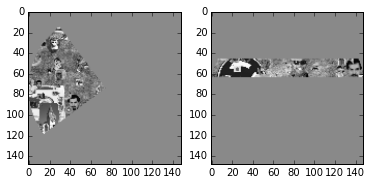

In [21]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(wedge_imgs[400,:,:],cmap=cm.gray)
plt.subplot(1,2,2)
plt.imshow(bar_imgs[400,:,:],cmap=cm.gray)

###Get predictions

In [7]:
results_db = '/media/tnaselar/Data/scratch/best_prf.pd'
best_prf = pd.read_pickle(results_db)

In [8]:
best_prf.head(2)

,kernel,size,freq,pos_x,pos_y,ang,ecc,voxels,model
0,"[[(2.08683242977e-88+2.25821927388e-88j), (2.7...",3.348404,11.05004,-45.6516,-70.6516,-2.144461,84.11728,"[8856, 8856, 8856, 8856]","Ridge(alpha=1, copy_X=True, fit_intercept=True..."
1,"[[(-2.27696165747e-121-3.42337372971e-123j), (...",3.348404,11.05004,-40.6516,-70.6516,-2.092917,81.51196,"[66381, 66381, 66381, 66381, 69007, 69007, 690...","Ridge(alpha=1, copy_X=True, fit_intercept=True..."


###Fit the ripple model
Loop over all prf sizes, frequencies, and positions. At each iteration fit an independent model for each voxel. Evaluate the score against a held-out selection set. Keep track of the best model for each voxel.

In [26]:
##some parameters of the model
hrf_length = 15 ##20 s should do it.
alpha = 1 ## I dunno. For rige regression

A special function we need for creating feature matrices w/o filling up memory.

In [27]:
def concat_wedge_bar_matrices(wedge_feature_matrix=None,bar_feature_matrix=None,run_ids=None):
    total_rows = data_db['nvols'].iloc[run_ids].sum(axis=0)
    total_cols = wedge_feature_matrix.shape[1]
    nVols = wedge_feature_matrix.shape[0]
    final_feature_matrix = np.zeros((total_rows,total_cols))
    count = 0
    for row in data_db.iloc[run_ids].iterrows():  ##apparently this gives you a tuple with the index first
        run_type = row[1].runType
        if run_type == 'bar':
            final_feature_matrix[count:count+nVols,:] = bar_feature_matrix
        elif run_type == 'wedge':
            final_feature_matrix[count:count+nVols,:] = wedge_feature_matrix
        else:
            raise Exception('run type should only be bar or wedge. something is wrong.')
        count += nVols
    return final_feature_matrix

A reasonbly efficient scoring function. Sklearn doesn't deal with scoring many models at once

In [28]:
def corr2_coeff(A,B):
    N = A.shape[0]
    # Colwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(0)[None,:]
    B_mB = B - B.mean(0)[None,:]

    # Sum of squares across cols
    ssA = (A_mA**2).sum(0) 
    ssB = (B_mB**2).sum(0) 
    ss = np.sqrt(ssA)*np.sqrt(ssB)
    # Finally get corr coeff
    return np.sum(A_mA*B_mB,axis=0)/ss
#     return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))

The main fitting / selection loop

In [29]:
##some containers for the results
model_idx = 0
num_voxels = training_vols.shape[1]
best_scr = np.zeros(num_voxels)
best_coefs = np.zeros((num_voxels,hrf_length))
best_intercept = np.zeros(num_voxels)
best_model_dx = np.zeros((num_voxels,4))
model_specs = []

##some functions for converting to polar coors on the fly. Should probably put these elsewhere
def ecc_func(x,y):
    return np.sqrt(x**2+y**2)

def ang_func(x,y):
    return np.angle(x+1j*y)


##loop over size / freq / position, updating the "best" model for each voxel on each iteration.
for pos in best_prf.iterrows():            
            wedge_features = np.abs(np.tensordot(wedge_imgs, pos['kernel'],axes=2))
            bar_features = np.abs(np.tensordot(bar_imgs, pos['kernel'],axes=2))
            downsampled_wedge_timeseries = preproc.nearest_neighbor_downsampling(wedge_features,wedge_nvols)
            downsampled_bar_timeseries = preproc.nearest_neighbor_downsampling(bar_features,bar_nvols)
  
            wedge_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_wedge_timeseries).T,
                                                                    hrf_length=hrf_length)
            bar_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_bar_timeseries).T,
                                                                    hrf_length=hrf_length)
            print '=scoring model...'
            val_matrix = concat_wedge_bar_matrices(wedge_feature_matrix=wedge_feature_matrix,
                                                             bar_feature_matrix=bar_feature_matrix,
                                                             run_ids = validation_runs)
            
            yhat = pos['model'].predict(val_matrix)
            scr = corr2_coeff(selection_vols,yhat)
            better = np.where(scr > best_scr)[0] ##<<not sure why the zero. but gotta have it.
            best_scr[better] = scr[better]
            best_coefs[better,:] = lin_mod.coef_[better,:]
            best_intercept[better] = lin_mod.intercept_[better]
            best_model_dx[better] = model_idx
            model_idx += 1
        

=====size/freq pair 0
constructing 841 filters
===position: 0 of 841
=fitting model...
=scoring model...
===position: 1 of 841
=fitting model...
=scoring model...
===position: 2 of 841
=fitting model...
=scoring model...
===position: 3 of 841
=fitting model...
=scoring model...
===position: 4 of 841
=fitting model...
=scoring model...
===position: 5 of 841
=fitting model...
=scoring model...
===position: 6 of 841
=fitting model...
=scoring model...
===position: 7 of 841
=fitting model...
=scoring model...
===position: 8 of 841
=fitting model...
=scoring model...
===position: 9 of 841
=fitting model...
=scoring model...
===position: 10 of 841
=fitting model...
=scoring model...
===position: 11 of 841
=fitting model...
=scoring model...
===position: 12 of 841
=fitting model...
=scoring model...
===position: 13 of 841
=fitting model...
=scoring model...
===position: 14 of 841
=fitting model...
=scoring model...
===position: 15 of 841
=fitting model...
=scoring model...
===position: 16 of 

In [30]:
int(.3*34.751*(148./768.))

2

Now we unpack the results into an organized database that (should) make future analyses easier

In [31]:
##construct and populate database with voxel indices and model parameters for selected models
best_prf = pd.DataFrame(columns=['kernel','size','freq','pos_x','pos_y','ang','ecc','voxels','model'])
new_model_dx = 0

for mm,mod_spec in enumerate(model_specs):
    these_vox = np.where(best_model_dx == mm)[0]
    if len(these_vox) < 1:
        pass
    else:
        best_prf.loc[new_model_dx,'voxels'] = these_vox
        model = linear_model.Ridge(alpha=alpha,normalize=True)
        model.coef_ = best_coefs[these_vox,:]
        model.intercept_ = best_intercept[these_vox]
        best_prf.loc[new_model_dx,'model'] = model
        best_prf.loc[new_model_dx, 'size'] = mod_spec['size']
        best_prf.loc[new_model_dx, 'freq']= mod_spec['freq']
        best_prf.loc[new_model_dx, 'pos_x'] = mod_spec['pos_x']
        best_prf.loc[new_model_dx, 'pos_y'] = mod_spec['pos_y']
        best_prf.loc[new_model_dx, 'ecc'] = mod_spec['ecc']
        best_prf.loc[new_model_dx, 'ang'] = mod_spec['ang']
        best_prf.loc[new_model_dx, 'kernel'] = complex_ripple_filter(mod_spec['freq'],
                                                                    (mod_spec['pos_x'],mod_spec['pos_y']),
                                                                     mod_spec['size'],
                                                                    pixels_per_stimulus)
        new_model_dx += 1
    

In [32]:
best_prf.head()

,kernel,size,freq,pos_x,pos_y,ang,ecc,voxels,model
0,"[[(2.08683242977e-88+2.25821927388e-88j), (2.7...",3.348404,11.05004,-45.6516,-70.6516,-2.144461,84.11728,"[8856, 8856, 8856, 8856]","Ridge(alpha=1, copy_X=True, fit_intercept=True..."
1,"[[(-2.27696165747e-121-3.42337372971e-123j), (...",3.348404,11.05004,-40.6516,-70.6516,-2.092917,81.51196,"[66381, 66381, 66381, 66381, 69007, 69007, 690...","Ridge(alpha=1, copy_X=True, fit_intercept=True..."
2,"[[(5.0591223947e-160-5.11800107975e-160j), (2....",3.348404,11.05004,-35.6516,-70.6516,-2.038126,79.13712,"[3245, 3245, 3245, 3245, 118255, 118255, 11825...","Ridge(alpha=1, copy_X=True, fit_intercept=True..."
3,"[[(2.35398193913e-205+9.701240487e-204j), (7.3...",3.348404,11.05004,-30.6516,-70.6516,-1.980132,77.01408,"[74341, 74341, 74341, 74341, 115417, 115417, 1...","Ridge(alpha=1, copy_X=True, fit_intercept=True..."
4,"[[(-4.10717947324e-253-3.78261984199e-253j), (...",3.348404,11.05004,-25.6516,-70.6516,-1.919069,75.16417,"[33553, 33553, 33553, 33553, 51901, 51901, 519...","Ridge(alpha=1, copy_X=True, fit_intercept=True..."


A histogram of scores on the selection set. Note there is some overfitting here, because we purposefully selected 
the best of many possible models for each voxel. Don't expect the histogram on the validation data to look quite this good.

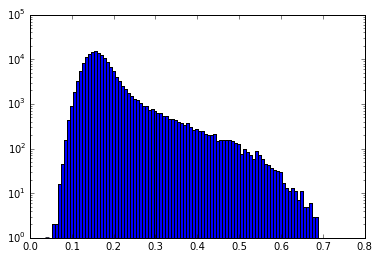

In [33]:
plt.figure
plt.hist(best_scr,100,log=True);

If we look at the temporal kernels for the best voxels (as evaluated on the selection set) we get some encouraging-looking results.

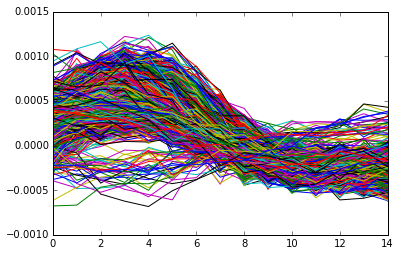

In [35]:
mxi = np.where(best_scr > 0.4)[0]
plt.figure
_ = plt.plot(best_coefs[mxi,:].T)


<Container object of 3118 artists>

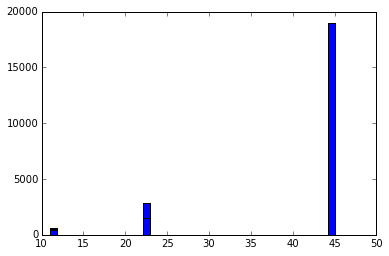

In [49]:
plt.bar(best_prf['freq'],best_prf['voxels'].apply(len))

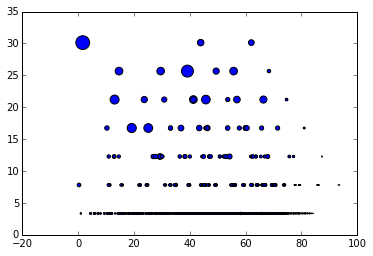

In [47]:
plt.scatter(best_prf['ecc'],best_prf['size'],s=best_prf['voxels'].apply(len)*.01)

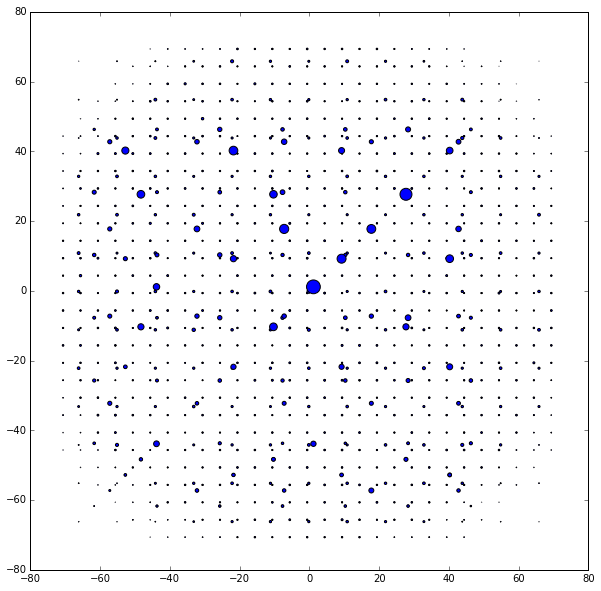

In [53]:
plt.figure(figsize=(10,10))
plt.scatter(best_prf['pos_x'],best_prf['pos_y'],s=best_prf['voxels'].apply(len)*.01)

In [ ]:
size_group = best_prf.groupby(by='size')
pos_x = []
pos_y = []
mean_size = []
for name,grp in siz_group:
    pos_x.append(grp.pos_x)
    pos_y.append(grp.pos_y)
    mean_size.append(grp['size'].mean())
    

In [ ]:
1+1

In [ ]:
best_prf.to_pickle('/media/tnaselar/Data/scratch/best_prf.pd')

We expect the map of scores (on the selection set) to look reasonable. It does. Check out the saved volumes in fslview.

In [39]:
mean_vol = preproc.load_runs(data_db,selection_runs,detrend=False,z_score=False)
mean_vol = apply_mask(mean_vol,mask_image.ravel()).mean(axis=0)

In [40]:
brain_view = np.zeros(mask_image.shape).ravel()
brain_view[mask_image.ravel()] = mean_vol
brain_view = brain_view.reshape(mask_image.shape)

score_view = np.zeros(mask_image.shape).ravel()
score_view[mask_image.ravel()] = best_scr
score_view = score_view.reshape(mask_image.shape)

In [41]:
nib.save(nib.Nifti1Image(brain_view,affine=np.eye(4)),'/media/tnaselar/Data/scratch/brain_view.nii')

In [42]:
nib.save(nib.Nifti1Image(score_view,affine=np.eye(4)),'/media/tnaselar/Data/scratch/score_view.nii')

###Model validation: prediction accuracy

see "analyze_best_fit_ripple"

###Model validation: inspect temporal kernels

###Model validation: size vs. eccentricity

###Model validation: projective imaging

In [ ]:
##bars
##wedges
